# Image reconstruction in X-ray tomography #

## 1. X-ray Tomography ##

In [85]:
import numpy as np
import scipy.io 
import matplotlib.pyplot as plt
import time

**Question 1**

In [86]:
H = scipy.io.loadmat(r'C:\Users\Essakine\Downloads\CT\data_LO\data\H.mat')['H']
x = scipy.io.loadmat(r'C:\Users\Essakine\Downloads\CT\data_LO\data\x.mat')['x']
N = 90 * 90
M = 90 * 180

**Question 2**

In [87]:
noise = np.random.normal(loc=0,scale=1,size=(H.shape[0],1))
y = H @ x + noise

**Question 3**

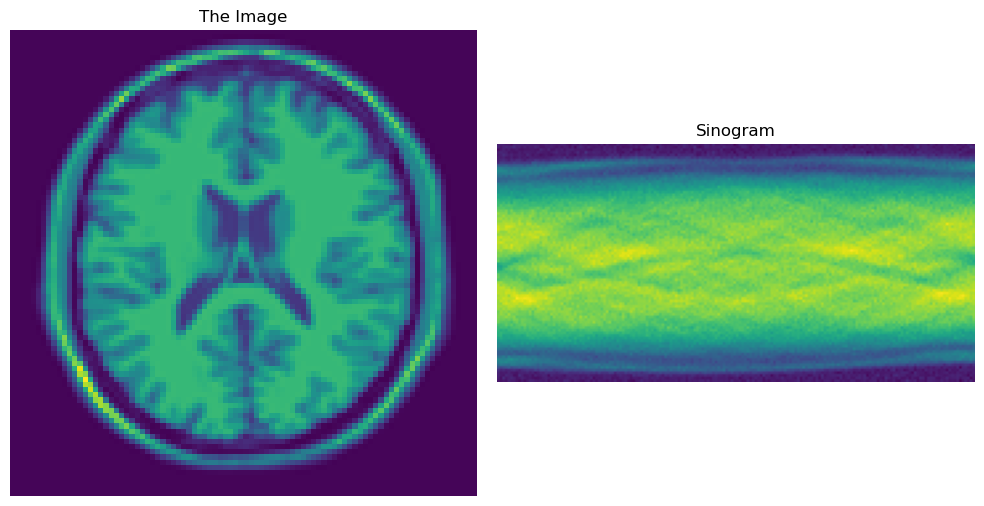

In [88]:
img_x = np.reshape(x,(90,90),order='F')
img_y = np.reshape(y,(90,180),order='F')

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  
plt.imshow(img_x)
plt.axis('off')  
plt.title("The Image")

plt.subplot(1, 2, 2)  
plt.imshow(img_y)
plt.axis('off')  
plt.title("Sinogram")

plt.tight_layout()
plt.show()

## 2. Optimization problem ##

For the reconstruction problem, the cost function is defined by 
$$ \forall x \in \mathbb{R}^N \text{  } f(x) = \frac{1}{2} \| Hx - y \|^2 + \lambda r(x)$$
Where the regulization function is defined by :
$$ r(x) = \sum_{i=1}^{2N} \psi((Gx)_n)$$
And $\psi$ is the potential function defined by :
$$\forall u \in \mathbb{R} \text{  ,  }  \psi(u) = \sqrt{1 + \frac{u^2}{\delta^2}} $$

**Question 1**

In [89]:
G = scipy.io.loadmat(r'C:\Users\Essakine\Downloads\CT\data_LO\data\G.mat')['G']
lambd = 0.13
delta = 0.02

In [90]:
psi = lambda u : np.sqrt(1 + u**2 / delta ** 2)
f = lambda x : 1 / 2 * np.sum((H.dot(x) - y)**2) + lambd * np.sum(psi(G @ x))

**Question 2**

The function $f$ is differentiable on $\mathbb{R}^N$ because the norm function is differentiable on $\mathbb{R}^N$. Furthermore, $r$ is differentiable on $\mathbb{R}^N$ since $\psi$ is differentiable on $\mathbb{R}$, and $r$ is the sum of these functions applied component-wise.
And the gradient is given by :
$$ \forall x \in \mathbb{R}^N \text{   } \nabla f (x) = H^T (Hx - y) + \lambda G^T \psi^{'}(Gx)$$
Where we apply $\psi^{'}$ is applied component wise to $Gx$. The derivative of $\psi$ is :
$$\psi^{'}(u) = \frac{u}{ \delta^2 \psi(u)}$$


In [91]:
def grad_f(x) :
    norm_grad = H.T @(H @ x - y)
    psi_grad = (G @ x) / (delta**2 * psi(G @ x))
    grad = norm_grad + lambd * (G.T @ psi_grad)
    return grad

**Question 3**

First, $\psi$ is twice derivable and the second derivative is given for $u \in \mathbb{R}$ by :

\begin{align*} 
    \psi^{''}(u) &= \frac{1}{\delta^2} \frac{\psi(u) - u \psi^{'}(x)}{\psi(x)^2} \\ 
            & = \frac{1}{\delta^2} \frac{\delta^2 \psi(u)^2 - u^2}{\delta^2 \psi(u)^3} \\ 
            & = \frac{1}{\delta^2} \frac{1}{\psi(x)^3}
\end{align*}
Since $\psi(u) \geq 1 $ for any $u$, we find that $\frac{1}{delta^2}$ is a Lipschtiz constant for $\psi$.\\ 
Let $x$ and $y$ $\in \mathbb{R}^N$ 
\begin{align*}
 \| \nabla f(x) - \nabla f(y) \| & = \| H^T H (x - y) + \lambda G^T (\psi^{'}(Gx) - \psi^{'}(Gy)) \| \\ 
                                 & \leq \| H^T \| \| H \| \|x - y \| + \lambda \|G^T\| \| \psi^{'}(Gx) - \psi^{'}(Gy) \| \\ 
                                 & \leq \| H \|^2 \| x - y\| + \lambda \| G^T \| \cdot \sum_{n=1}^{2N} | \psi^{'}((Gx)_n) - \psi^{'}((Gy)_n) | \\ 
                                 & \leq (\|H\|^2 + \lambda \|G^T \| \cdot \frac{\|G\|}{\delta^2}) \|x-y\| \\ 
                                 & \leq (\|H\|^2 + (\lambda/\delta^2) \| G \|^2) \| x - y \|
 \end{align*}
 Hence $\|H\|^2 + (\lambda/\delta^2) \| G \|^2$ is a Lipschtiz constant for $\nabla f$.

In [92]:
u_H, s_H, vT_H  =  scipy.sparse.linalg.svds(H,k=1)
norm_H = s_H[0]
u_G, s_G, vT_G  =  scipy.sparse.linalg.svds(G,k=1)
norm_G = s_G[0]
L = norm_H**2 + (lambd / (delta**2)) * norm_G**2
L

18092.77327686479

## 3. Optimization algorithms ##

### 3.1 Gradient descent ###

In [147]:
def visualize_images(x_fin) :
    img_x = np.reshape(x,(90,90),order='F')
    img_x_fin = np.reshape(x_fin,(90,90),order='F')

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)  
    plt.imshow(img_x)
    plt.axis('off')  
    plt.title("Original image")

    plt.subplot(1, 2, 2)  
    plt.imshow(img_x_fin)
    plt.axis('off')  
    plt.title("Reconstruction image")

    plt.tight_layout()
    plt.show()

def visualize_sinogrames(x_fin):
    y = H @ x + noise
    y_fin = H @ x_fin + noise
    img_y = np.reshape(y,(90,180),order='F')
    img_y_fin = np.reshape(y_fin,(90,180),order='F')
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)  
    plt.imshow(img_y)
    plt.axis('off')  
    plt.title("Original image")

    plt.subplot(1, 2, 2)  
    plt.imshow(img_y_fin)
    plt.axis('off')  
    plt.title("Reconstruction image")

    plt.tight_layout()
    plt.show()

**Question 1**

In [94]:
# Creat vector with zero entries to be our initialization
x0 = np.zeros_like(x)
eps = np.sqrt(N) * 1e-4

**Question 2**

In [95]:

#Implementation of the gradient descent algorithm
def gradient_descent(x0=x0,grad_f=grad_f,eps =eps,max_iterations=1500):
    x_hat = np.copy(x0)
    history = [x_hat]
    times = []
    gradients = []
    f_values = []
    counter = 0
    t0 = time.time()
    
    while np.linalg.norm(grad_f(x_hat)) > eps :   
        grad = grad_f(x_hat)
        x_new = x_hat - 1/L * grad   
        x_hat = x_new
        history.append(np.copy(x_hat))
        times.append(time.time() - t0)
        gradients.append(grad)
        f_values.append(f(x_hat))
        counter += 1
    
    return x_hat,history,gradients,f_values,times

In [96]:
x_gd,history_gd,gradients_gd,f_values_gd,times_gd = gradient_descent(eps = eps)
print('gradient decesent algorithm finished in',times_gd[-1],'seconds')

gradient decesent algorithm finished in 160.16169953346252 seconds


### 3.2 Quadratic MM ###

**Question 4**

Let's find a majorant of the function $f$. First, the quadratic term is majorized at $x$ by :
$$\forall z \in \mathbb{R^N} \text{ , } h_1(z,x) = \frac{1}{2} \| Hx - y \| + < H^T(Hx - y),z - x> + \frac{1}{2} (z-x)^T H^T H (z - x)$$
The curvature of this function is given by the matrix $H^T H$. 

For the regulization term $r$, we can notice that $\psi$ is an even differentiable function, $\psi(\sqrt{.})$ is concave on $]0,+\infty[$, $\psi^{'}(x) \geq 0 $ for all $x \in \,\mathbb{R}$ and $\lim_{u \to 0} \frac{\psi^{'}(x)}{x} \in \mathbb{R}$. Hence a majorant for $\psi$ is :
 $$\forall v \in \mathbb{R} \text{ , } h_{psi}(v,u) = \psi(u) + \psi^{'}(u)(v-u) + \frac{1}{2} w(u) (v - u)^2 $$
 Where $w(u) = \frac{\psi^{'}(u)}{u} = \frac{1}{\delta^2 \sqrt{(1 + \frac{u^2}{\delta^2})}} $

 Hence a majorant of $r(x)$ is :
$$\forall z \in \mathbb{R^N} \text{ , } h_2(z,x)= r(x) + G^T \psi^{'}(Gx)(x-z) + \frac{1}{2} (z - x) G^T B(x) G (z-x)^T$$
Where $B(x) = diag(w((Gx)_n)) $

A quadratic majorant for $f$ is then $h_1(z,x) + \lambda h_2(z,x) $ and the curvature is given by : 
$$A(x) = H^T H + \lambda G^T B(x) G$$

In [23]:
w = lambda u : 1 / (delta**2 * np.sqrt(1 + u**2 / delta ** 2))

def curvature(x) :
    d = w(G @ x)
    D = scipy.sparse.diags(d[:,0]).tocsc()
    return lambda v : H.T @ (H @ v) + lambd * (G.T @ D @ G @ v)

In [24]:
def MM_quadratic(x0=x0,grad_f=grad_f,curvature=curvature,eps=1e-6,max_iterations=1500) :
    x_hat = np.copy(x0)
    history = [x_hat]
    times = []
    gradients = []
    f_values = []
    counter = 0
    t0 = time.time()
    
    while np.linalg.norm(grad_f(x_hat)) > eps :   
        grad = grad_f(x_hat)
        A = scipy.sparse.linalg.LinearOperator(shape=(N, N), 
                                             matvec= curvature(x_hat), 
                                             rmatvec= curvature(x_hat))
        x_new = x_hat - scipy.sparse.linalg.bicg(A=A, b=grad)[0].reshape(-1,1)
        x_hat = x_new
        history.append(np.copy(x_hat))
        times.append(time.time() - t0)
        gradients.append(grad)
        f_values.append(f(x_hat))
        counter += 1
    
    return x_hat,history,gradients,f_values,times

In [25]:
x_mm,history_mm,gradients_mm,f_values_mm,times_mm = MM_quadratic(eps = eps)
print('MM quadratic algorithm finished in',times_mm[-1],'seconds')

MM quadratic algorithm finished in 34.5817289352417 seconds


### 3.3 3MG algorithm ###

In [105]:
def MG_algorithm(x0=x0,grad_f=grad_f,eps=1e-6,max_iterations=1500):
    x_hat = np.copy(x0)
    history = [x_hat]
    times = []
    gradients = []
    f_values = []
    counter = 0
    t0 = time.time()
    x_old =  np.random.rand(*x0.shape)
    grad = grad_f(x_hat)
    
    while np.linalg.norm(grad) > eps  : 
        grad = grad_f(x_hat)
        if counter == 0:
            D_k= - grad_f(x).reshape(-1,1) 
        d = w(G @ x_hat)
        Diag = scipy.sparse.diags(d[:,0]).tocsc()
        mat = (H @ D_k).T @ (H @ D_k) + lambd * (G @ D_k).T @ Diag @ (G @ D_k)
        mat_inv = scipy.linalg.pinv(mat)
        u_k = - mat_inv @ (D_k.T @ grad) 
        x_hat = x_hat + D_k @ u_k
        D_k = np.column_stack([-grad, x_hat - x_old])  
        x_old = np.copy(x_hat)
        history.append(np.copy(x_hat))
        times.append(time.time() - t0)
        gradients.append(grad)
        f_values.append(f(x_hat))
        counter += 1
    
    return x_hat,history,gradients,f_values,times

In [106]:
x_mg,history_mg,gradients_mg,f_values_mg,times_mg = MG_algorithm(eps = eps)
print('3MG algorithm finished in',times_mg[-1],'seconds')

3MG algorithm finished in 51.44974136352539 seconds


### 3.4 Block-coordinate MM quadratic algorithm ###

In [32]:
def curvature_block(x,Nj,j) :
    start_idx = Nj * (j - 1) 
    end_idx = Nj * j
    
    G_j = G[..., start_idx:end_idx].tocsc()
    H_j = H[..., start_idx:end_idx].tocsc()
    
    d_j = w(G_j @ x)
    D_j = scipy.sparse.diags(d_j[:,0]).tocsc()
    return lambda v : H_j.T @ (H_j @ v) + lambd * (G_j.T @ D_j @ G_j @ v)


In [57]:
def blockMM(K=9,x0=x0,grad_f=grad_f,eps=1e-6,max_iterations=1500) :
    x_hat = np.copy(x0)
    history = [x_hat]
    times = []
    gradients = []
    f_values = []
    counter = 0
    t0 = time.time()
    grad = grad_f(x_hat)
    
    while np.linalg.norm(grad) > eps  :  
        j = counter % K + 1
        Nj = N // K
        start_idx = Nj * (j - 1) 
        end_idx = min(Nj * j, N)
        xj = x_hat[start_idx:end_idx]
        grad = grad_f(x_hat)
        A_j = scipy.sparse.linalg.LinearOperator(shape=(Nj, Nj), 
                                             matvec= curvature_block(xj,Nj,j), 
                                             rmatvec= curvature_block(xj,Nj,j))
        delta_xj = scipy.sparse.linalg.bicg(A=A_j, b=grad[start_idx:end_idx])[0].reshape(-1,1)
        x_hat[start_idx:end_idx] -= delta_xj.reshape(-1, 1)
        history.append(np.copy(x_hat))
        times.append(time.time() - t0)
        gradients.append(grad)
        f_values.append(f(x_hat))
        counter += 1
    
    return x_hat,history,gradients,f_values,times

In [60]:
results = {}
K_values = [2, 3, 5, 6,9]
for K in K_values:
    print(f"Testing for K = {K}")
    x_hat, history, gradients, f_values, times = blockMM(K=K,eps=eps)
    results[K] = {
        'solution': x_hat,
        'history': history,
        'gradients': gradients,
        'f_values': f_values,
        'times': times
    }
    print(f"Runing time: {times[-1]} 'seconds'\n")

Testing for K = 2
Runing time: 67.9444649219513 'seconds'

Testing for K = 3
Runing time: 66.07917094230652 'seconds'

Testing for K = 5
Runing time: 97.33258295059204 'seconds'

Testing for K = 6
Runing time: 98.01403784751892 'seconds'

Testing for K = 9
Runing time: 140.15959978103638 'seconds'



### 3.5 Parallel MM quadratic algorithm ###

**Question 1**

Let $H \in \mathbb{R}^{M \cdot N}$ and $G \in \mathbb{R^{2N \cdot N}}$
$B$ a diagonal matrice $\in \mathbb{R^N}$ whose entries are (for $1 \leq i \leq N )$
$$b^i(x) = C_i^T \mathbf{1} + \lambda D_i^T $$
Where $C_i \in \mathbb{R^M}. (C_i)_m = \sum_{p = 1}^N | H^{(m,i)} | |H^{(m,p)} |$ and $D_i \in \mathbb{R^{2N }}. (D_i)_m = \sum_{p = 1}^N | G^{(m,i)} | |G^{(m,p)} |$ 

Let us prove that $B - A$ is a positive semi definte matrice. First we prove that $B - A$ is a diagonally dominant matrix i.e :
$$\forall i \in \{1,...,n\} \text{   ,   } |a_{i,i}| \geq \sum_{j \neq i} |a_{i,j}|$$
Let $i$ be in $\{1,...,n\}$. 

\begin{align*}
b^i(x) &= \mathcal{H}^T \mathbf{1} + \lambda \mathcal{G}^T (\frac{\psi^{'}(Gx)}{Gx}) \\ 
       &= \sum_{m = 1}^M \sum_{p = 1}^N | H^{(m,i)} | |H^{(m,p)} | + \lambda \sum_{n=1}^{2N} \sum_{p=1}^N | G^{(n,i)} | | G^{(n,p)} | \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \\ 
       &= \sum_{p = 1}^N \left[ \sum_{m = 1}^M | H^{(m,i)} | |H^{(m,p)} | +  \lambda \sum_{n=1}^{2N} | G^{(n,i)} | | G^{(n,p)} | \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \right]
\end{align*}
On the other hand :
\begin{align*}
A(x)^{(i,j)} &= (H^T H + \lambda G^T C_x G)^{(i,j)} \\ 
             &= \sum_{m = 1}^M  H^{(m,i)}  H^{(m,p)} + \lambda \sum_{n=1}^{2N}  G^{(n,i)}  G^{(n,p)} \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}}
\end{align*}
Hence $A(x)^{i,i}$ is exactly the term in $b^i$ when $p = i$ and without the absolute value 
\begin{align*}
(B(x) - A(x))^{(i,i)} &= \sum_{p \neq i} \left[ \sum_{m = 1}^M | H^{(m,i)} | |H^{(m,p)} | +  \lambda \sum_{n=1}^{2N} | G^{(n,i)} | | G^{(n,p)} | \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \right] + \sum_{m = 1}^M  \left( | H^{(m,i)} | |H^{(m,p)} | - H^{(m,i)}  H^{(m,p)} \right) + \lambda \sum_{n=1}^{2N}  \left( | G^{(n,i)} | | G^{(n,p)} | \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} - G^{(m,i)} G^{(m,p)} \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \right) \\ 
                      & \geq \sum_{p \neq i} \left[ \sum_{m = 1}^M | H^{(m,i)} | |H^{(m,p)} | +  \lambda \sum_{n=1}^{2N} | G^{(n,i)} | | G^{(n,p)} | \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \right] \\
                      & \geq \sum_{p \neq i} \left| \sum_{m = 1}^M  H^{(m,i)}  H^{(m,p)}  +  \lambda \sum_{n=1}^{2N}  G^{(n,i)}   G^{(n,p)}  \frac{\psi^{'}((Gx)^{n})}{(Gx)^{n}} \right| \\ 
                      & \geq \sum_{p \neq i} | (B - A)^{(i,j)} |
\end{align*}
By using the triangle inequality and that $\forall x \in \mathbb{R^*} \text{  ,  } \frac{\psi^{'}(x)}{x} \geq 0$.

Hence, the matrice $B - A$ is diagonally dominant matrice, and this proves that its a PSD matrice since $B - A$ is a symetrice matrice. This is because we know that its eigenvalues are real, and by using Gershgorin circle theorem, the eigenvalues lies in at least one of the Gershgorin discs, but since the matrice is diagonally dominant, Gershgorin discs does not contain any negative real number which proves all the eigenvalues are positive. Hence :
$$A \preceq	B$$ 

**Question 2**

We now propose a parallel MM quadratic algorithm. As established in the previous discussion, the quadratic function with curvature $B$ also serves as a valid majorant of $f$. Therefore, we will utilize it in the MM algorithm as an alternative to the majorant function proposed in Section 3.2. Since B is diagonal, the update of each component x_{k+1}^i depends only on its diagonal entry b_i(x_k) via the update formula :
$$x_{k+1}^{i} = x_k^i - \frac{(\nabla f(x_k))_i}{b_i(x_k)}$$
The update can be done in parallel across all the components.

In [61]:
import numpy as np
from scipy.sparse import diags
from joblib import Parallel, delayed


import numpy as np



def compute_B(x):
    G_abs, H_abs = np.abs(G), np.abs(H)
    G_sum = scipy.sparse.diags(G_abs.toarray().sum(axis=1)).tocsc()
    H_sum = scipy.sparse.diags(H_abs.toarray().sum(axis=1)).tocsc()
    G_cal, H_cal = G_sum @ G_abs, H_sum @ H_abs
    H_cal_sum = H_cal.sum(axis=0)
    return np.asarray(H_cal_sum + lambd * G_cal.T @ (1 / psi(G @ x))).squeeze()
    

def Parallel_MM_quadratic(x0=x0,grad_f=grad_f,eps=1e-6,max_iterations=1500,n_jobs = -1) :
    x_hat = np.copy(x0)
    history = [x_hat]
    times = []
    gradients = []
    f_values = []
    counter = 0
    t0 = time.time()
    
    while np.linalg.norm(grad_f(x_hat)) > eps and counter < max_iterations :   
        grad = grad_f(x_hat)
        B_diag = compute_B(x_hat)
        def update_i(i):
            return x_hat[i] - grad[i] / B_diag[i]
        x_hat = np.array(Parallel(n_jobs=n_jobs)(delayed(update_i)(i) for i in range(len(x_hat))))
        history.append(np.copy(x_hat))
        times.append(time.time() - t0)
        gradients.append(grad)
        f_values.append(f(x_hat))
        counter += 1
    
    return x_hat,history,gradients,f_values,times    


**Question 1**

In [22]:
psi = lambda u : np.sqrt(1 + u**2 / delta ** 2)
f = lambda x : 1 / 2 * np.sum((H.dot(x) - y)**2) + lambd * np.sum(psi(G @ x))

**Question 2**

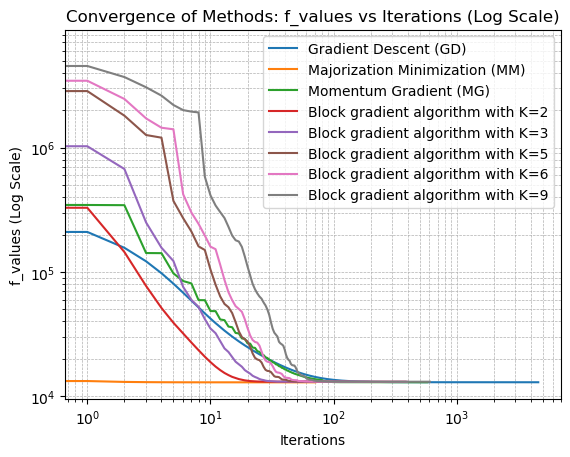

In [142]:
plt.plot(range(len(f_values_gd)), f_values_gd, label='Gradient Descent (GD)')
plt.plot(range(len(f_values_mm)), f_values_mm, label='Majorization Minimization (MM)')
plt.plot(range(len(f_values_mg)), f_values_mg, label='Momentum Gradient (MG)')
for K, data in results.items():
    plt.plot(range(len(data['f_values'])), data['f_values'], label=f"Block gradient algorithm with K={K}")
plt.title('Convergence of Methods: f_values vs Iterations (Log Scale)')
plt.xlabel('Iterations')
plt.ylabel('f_values (Log Scale)')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.show()

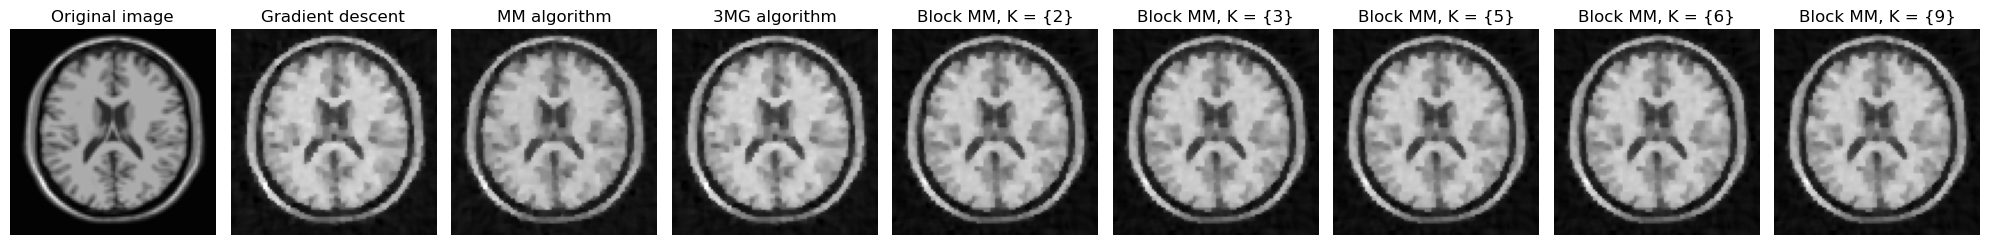

In [164]:
L_solution = [x_gd,x_mm,x_mg]
for K, data in results.items():
    L_solution.append(data['solution'])
annotate = ['Gradient descent','MM algorithm',"3MG algorithm","Block MM, K = {2}","Block MM, K = {3}","Block MM, K = {5}","Block MM, K = {6}","Block MM, K = {9}"]
def visualize_images_subplot(i,x_fin) :
    img_x_fin = np.reshape(x_fin,(90,90),order='F')
    plt.subplot(1, len(L_solution)+1, i + 2)
    plt.imshow(img_x_fin, cmap='gray')
    plt.title(annotate[i])
    plt.axis('off')

    
plt.figure(figsize=(20, 20))
plt.subplot(1, len(L_solution)+1, 1)
plt.imshow(img_x, cmap='gray')
plt.title('Original image')
plt.axis('off')
for l in range(len(L_solution)):
    visualize_images_subplot(l,L_solution[l])
plt.tight_layout()
plt.show()

**Question 3**

In [157]:
nb_points = 4
SNR = lambda x_hat : 10 * np.log10(np.sum(x ** 2) / np.sum((x - x_hat) ** 2))

lambda_range = np.linspace(0.5, 2, 4, endpoint=True)
delta_range = np.linspace(0.5, 2, 4, endpoint=True)


best_SNR = - np.inf
best_approx = None
best_lambda = None
best_delta = None

for i in range(nb_points) :
    for j in range(nb_points):
        lambd = lambda_range[i]
        delta = delta_range[j]
        x_,history_,gradients_,f_values_,times_ = MM_quadratic(eps = eps)
        snr = SNR(x_)
        print(snr)
        if snr > best_SNR :
            best_SNR = snr
            best_delta = delta
            best_lambda = lambd


10.63970455463128
7.358251153133012
5.095936372061223
3.3060820516794505
12.556150504641346
9.202344060479442
7.193676724629495
5.5842774517795535
13.77708948364727
10.210867393125307
8.279799383044129
6.786088783151611
14.68503011535912
10.932483342667936
9.003998597195777
7.577830984114585


In [158]:
print(f"Best SNR: {best_SNR:.2f}")
print(f"Best lambda: {best_lambda}")
print(f"Best delta: {best_delta}")

Best SNR: 14.69
Best lambda: 2.0
Best delta: 0.5
